## Imports

In [184]:
# MATLAB code from https://github.com/briandaniel/KroghCylinderModel
# Brian Hong 6-19-19
# File determines the equations of the Krogh cylinder model of oxygen
# transport used in Mcguire, Secomb (2001)

# Adapted to Python by Emma Bluemke 2021

# This import registers the 3D projection, but is otherwise unused.

from mpl_toolkits.mplot3d import Axes3D  
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib inline
import numpy as np
import scipy
import math
from scipy import integrate

## Parameters 
(Formerly called "KroghParams.m")

In [185]:
# param = value % Units | Description
Pb = 100; # Torr | Average partial pressure of oxygen in blood at capillary entrance 
P50 = 26; # Torr | Half-maximal hemoglobin saturation
n = 2.7; # - | Hill equation exponent
Cb = 0.2; # cm^3 O_2/cm^3 blood | Oxygen carrying capacity of blood
Sh = 2.5; # - | Sherwood number
Kpl = 8.3e-10; # (cm^2/s)[cm^3 O_2 /(cm^3*Torr)] | Krogh diffusion constant in plasma

# prm.Vbar = 2.25; # mm/s | Average blood flow
Vbar = 2.25e-1; # cm/s | Average blood flow
# prm.Vbar = 3.49e-1; # cm/s | Average blood flow
K = 9.4e-10; # (cm^2/s)[cm^3 O_2 /(cm^3*Torr)] | Krogh diffusion constant in tissue

# NOTE: In the text [M0] are is listed as cm^3 *100 cm^3/min, but should be
# listed as cm^3/(100 cm^3 * min )
# prm.M0 = 40; % cm^3 O_2 (100 cm^3*min) | Oxygen demand 
M0 = 40/6000; # cm^3 O_2 / ( cm^3*s ) | Oxygen demand

P0 = 1; # Torr | Half-maximal oxygen consumption
Dmb = 1.73e-7; # cm^2/s | Myoglobin diffusion coefficient
Cmb = 3.83e-7; # mol/cm^3 | Concentration of myoglobin
P50mb = 3.2; # Torr | Pressure where myoglobin 50% saturated with Oxygen

Vm = 2.24e4; # cm^3 | Molar volume
Mt = 6.52e-9;# (cm^2/s)[cm^3 O_2 /(cm^3*Torr)] | Mass transfer coef

# From the text
#Rc = 2.5; # microns | Capillary radius
#L = 0.5; # mm | Capillary length
#Rt = 26; # microns | Tissue Cylinder radius

# Converted to consistent units
Rc = 2.5e-4; # cm | Capillary radius
L = 0.5e-1; # cm | Capillary length
Rt = 26e-4; # cm| Tissue Cylinder radius


# Numerical params
Nz = 500;
Nr = 500;


## Internal functions 
These seem to work fine in python now

In [186]:
def guess(r):
    g =(1+r*0, 0*r); # guessing that everything is 0 and 1
    return(g)

def diffusionODE_BC(Ya,Yb):
    P_Rc = Ya[0]
    dPdr_Rc = Ya[1] # pressure at this initial boundary is the more complicated condition
    
    dPdr_Rt = Yb[1] # pressure at the boundary is 0
    
    res1 = 2*math.pi*Rc*K*dPdr_Rc + Mt*(Pb-P_Rc) # condition inside capillary 
    res2 = dPdr_Rt;
    
    res = (res1,res2)
    return(res)

def diffusionODE(r,Y):
    #NOTE: Y(1) = P, Y(2) = u, where u is the aux variable u = P'
    P = Y[0];
    u = Y[1];
     # Brian - why is this here?? Scared to remove - will it break things?
     
    # Oxygen consumption rate (per unit volume)
    MP = M0*(P/(P0+P));

    # In this case the derivatve is directly evaluated
    dudr = -u/r + 1/K*MP;
    dPdr = u;
    
    dY = (dPdr,dudr);
    return(dY)

## ODE part - This is the part I have questions about - replacing the MATLAB functions
I think solve_bvp from scipy will be able to be used here, but I'm not sure? https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_bvp.html

In [187]:
z = np.linspace(0,L,Nz)
r_tissue = np.linspace(Rc,Rt,Nr)

Psltn = np.zeros((Nr,Nz))


for k in range(0,Nz):
    if k>0: ### this loop works fine
        # compute the integral
        MP = M0*(P/(P0+P))
        q = 2*math.pi*np.trapz(r,MP*r)
        Shbi = (Pb/P50)**n/(1+(Pb/P50)**n)
        Ci = Cb*Shbi;
        dz = z[k]-z[k-1]
        volFlowRate = Vbar*math.pi*Rc**2
        Ciplus1 = Ci-dz*(q/volFlowRate)      
        Pb = P50*(Ciplus1/(Cb - Ciplus1))**(1/n) 

   # solinit = bvpinit(r_tissue, @guess );
    ### need to replace
    #solinit = bvpinit(x,yinit) uses the initial mesh x and initial solution guess yinit 
    #to form an initial guess of the solution for a boundary value problem. You then can 
    #use the initial guess solinit as one of the inputs to bvp4c or bvp5c to solve the 
    #boundary value problem.
    
    # so I think I need https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_bvp.html???

    #odeFunc = @(r,Y) diffusionODE(r,Y,P0,M0,K); # ### need to replace - output is dY = (dPdr,dudr); 
    #bcFunc = @(ya,yb) diffusionODE_BC(Ya,Yb,Pb,K,Rc); # ### need to replace - output is res = (res1,res2);

    # x and y are the independent variable and y is the dependent
    # "y" in the python function input is the initial guesses which is solinit here 
    # r is the independent and Y contains two elements, u and P which are dependent variables that you're solving for 
    #sol = bvp4c(odeFunc, bcFunc, solinit); ### need to replace
    
    init_y=guess(r_tissue)
    
    solution=scipy.integrate.solve_bvp(diffusionODE, diffusionODE_BC, r_tissue, init_y, verbose=0)
    #sol = bvp4c(odefun,bcfun,solinit) integrates a system of differential equations 
    #of the form yâ€² = f(x,y) specified by odefun, subject to the boundary conditions 
    #described by bcfun and the initial solution guess solinit. Use the bvpinit function 
    #to create the initial guess solinit, which also defines the points at which the 
    #boundary conditions in bcfun are enforced.

    #P = interp1(sol.x,sol.y(0,:),r_tissue ); ### need to replace
    #vq = interp1(x,v,xq) returns interpolated values of a 1-D function at 
    #specific query points using linear interpolation. Vector x contains 
    #the sample points, and v contains the corresponding values, v(x). 
    #Vector xq contains the coordinates of the query points.
    
    r = r_tissue;
    
    r_plot = np.linspace(Rc,Rt,Nr)
    y_plot = solution.sol(r_plot)[0]
    
    P=y_plot;
    
    Psltn[:,k] = P; # array of nr by nz here, the p here is the value along the grid that you're computing from your solution

    #print('Solving step k = ', str(k), '/', str(Nz))



## The 3D surf plot

In [188]:
import matplotlib.colors as colors

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('cool')
new_cmap = truncate_colormap(cmap, 0.2, 1)


# Make data.
X = np.linspace(Rc,Rt,Nr)
Y = np.linspace(0, L, Nz)
X, Y = np.meshgrid(X, Y)
Z=Psltn

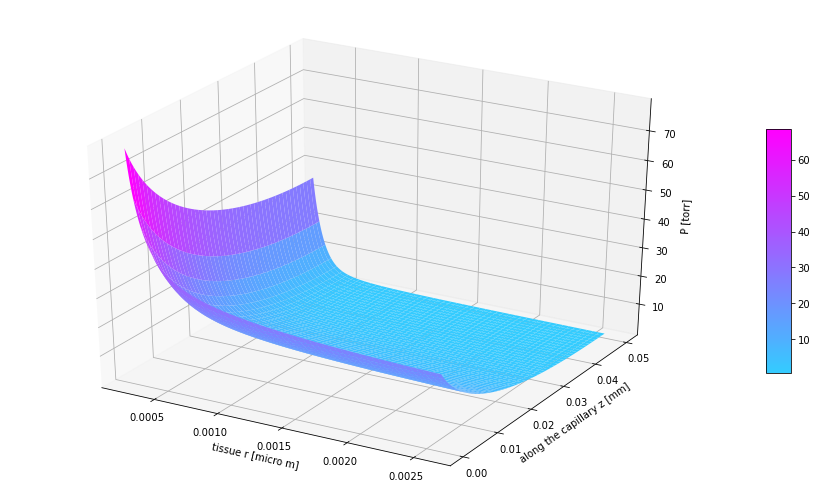

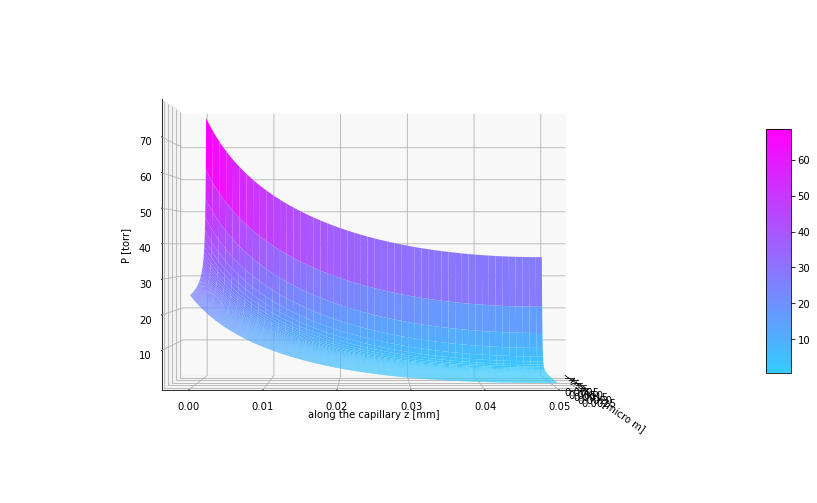

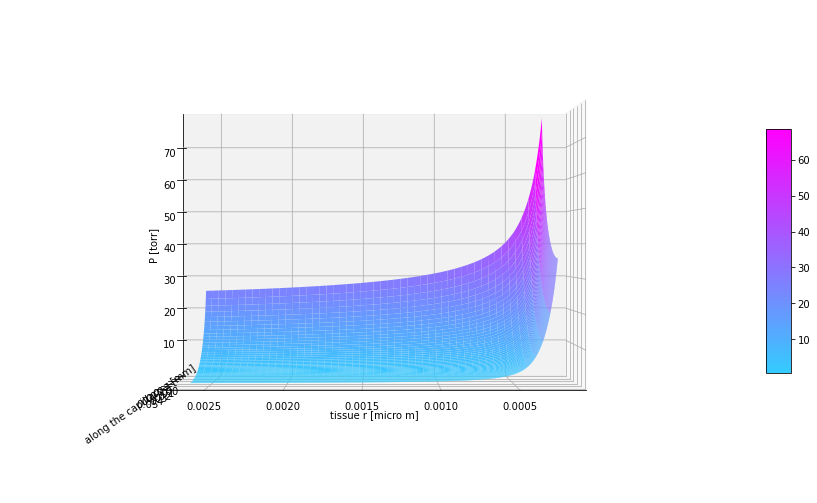

In [190]:
fig = plt.figure()
plt.rcParams["figure.figsize"] = [16,9]
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X,Y, Z, cmap=new_cmap,
                       linewidth=1)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)

ax.set_ylabel('along the capillary z [mm]')
ax.set_xlabel('tissue r [micro m]')
ax.set_zlabel('P [torr]')

plt.show()

fig = plt.figure()
ax = fig.gca(projection='3d')
plt.rcParams["figure.figsize"] = [16,9]

surf = ax.plot_surface(X,Y, Z, cmap=new_cmap,
                       linewidth=0.1)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)

ax.set_ylabel('along the capillary z [mm]')
ax.set_xlabel('tissue r [micro m]')
ax.set_zlabel('P [torr]')
ax.view_init(0, 0)

plt.show()


fig = plt.figure()
plt.rcParams["figure.figsize"] = [16,9]
ax = fig.gca(projection='3d')

surf = ax.plot_surface(X,Y, Z, cmap=new_cmap,
                       linewidth=1)

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=10)

ax.set_ylabel('along the capillary z [mm]')
ax.set_xlabel('tissue r [micro m]')
ax.set_zlabel('P [torr]')
ax.view_init(0,90)

plt.show()


## 2D Plots

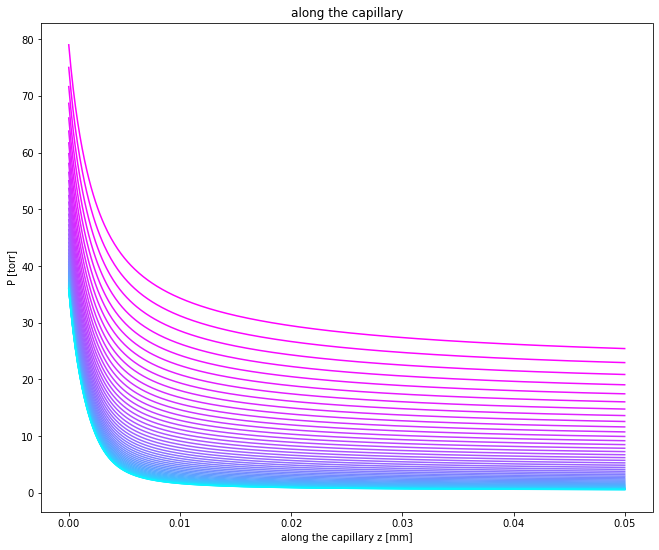

In [191]:
X = np.linspace(Rc,Rt,Nr)
Y = np.linspace(0, L, Nz)

fig = plt.figure()
ax = fig.add_subplot(111)
            
for i in range(0,len(Z),10):
    plt.plot(Y,Z[i])


colormap = plt.cm.cool_r #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0,0.95,len(ax.lines))]
for i,j in enumerate(ax.lines):
    j.set_color(colors[i])
ax.set_aspect(0.8/ax.get_data_ratio(), adjustable='box')

plt.title(str('along the capillary'))
plt.xlabel('along the capillary z [mm]')
plt.ylabel('P [torr]')
plt.show()

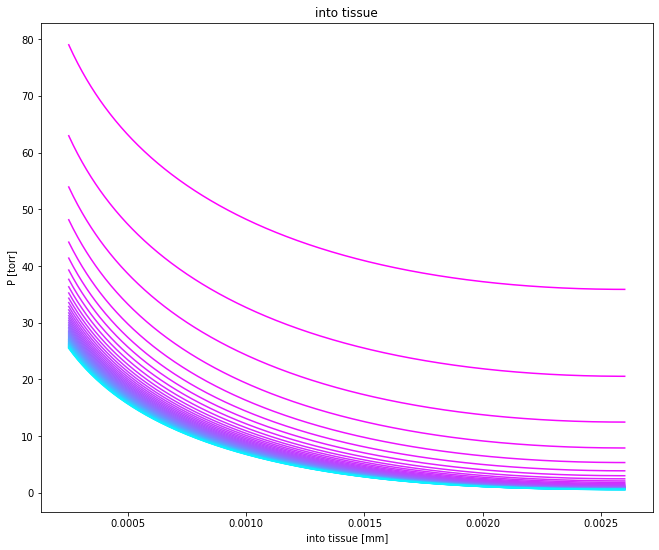

In [192]:
fig = plt.figure()
ax = fig.add_subplot(111)
            
for i in range(0,len(Z),10):
    plt.plot(X,Z[:,i])

colormap = plt.cm.cool_r #nipy_spectral, Set1,Paired   
colors = [colormap(i) for i in np.linspace(0,0.95,len(ax.lines))]
for i,j in enumerate(ax.lines):
    j.set_color(colors[i])
ax.set_aspect(0.8/ax.get_data_ratio(), adjustable='box')

plt.title(str('into tissue'))
plt.xlabel('into tissue [mm]')
plt.ylabel('P [torr]')
plt.show()